In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tester import dump_classifier_and_data, test_classifier
import warnings
warnings.filterwarnings('ignore')

from feature_format import featureFormat, targetFeatureSplit


%matplotlib inline
pd.set_option('display.max_columns', None)

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
    
financialFeatures= ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
emailFeatures =  ['to_messages', 'from_poi_to_this_person', 'from_messages',
                   'from_this_person_to_poi', 'shared_receipt_with_poi']


C:\Users\zi9618\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading the Pickle File into Pandas Data Frame

In [2]:
#We will load our dataset into a pandas dataframe here and run some basic analysis 

file = 'final_project_dataset.pkl'
enron = pd.DataFrame(pd.read_pickle(file)).transpose()
enron.head(5)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,NaN,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,NaN,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,NaN,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,NaN,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


# Utility Functions to Analyse Data Loaded in Pandas Data Frame

* The following utility functions analyse the enron data:
* 1) To identify total features
* 2) To identify persons of interest
* 3) To replace 'NaN' with np.nan 
* 4) To convert the null values in the financial features to zero 
* 5) To impute the null values in the email features with the mean of the column

In [3]:
def transform_null(dataframe,financialFeatures,emailFeatures):
    '''
    This function transforms the null values in the financial data to zero, 
    and imputes the null values in the email features with the mean of the column
    '''

    for feature in dataframe.columns:
        if feature in financialFeatures:
            dataframe[feature] = dataframe[feature].fillna(0)
        elif feature in emailFeatures:
            mean = dataframe[feature].mean()
            dataframe[feature] = dataframe[feature].fillna(mean)
    
    return dataframe
    
    
def convert_to_NaNs(dataframe):
    '''
    The function converts all the occurrences of NaNs to np.nan
    '''
    for col in dataframe.columns:
        dataframe[col] = dataframe[col].apply(lambda x: np.nan if str(x).strip()=='NaN' else x)
    
    nullByRow,nullByColumn = (nullValues(dataframe))
    
    return dataframe,nullByRow,nullByColumn
   
def nullValues(dataframe):
    '''
    The function counts null values by rows and columns
    '''
    nullByRow = dataframe.isnull().sum(axis=1)
    nullByColumn = dataframe.isnull().sum(axis=0)
    
    
    return nullByRow,nullByColumn
 
def inspect_data(dataframe):
    '''
    The function...
    '''
    
    print('There are {} features, and {} persons in the enron data \n'.format(len(dataframe.columns),len(dataframe.index)))
    
    poi_npoi = dataframe['poi'].value_counts().to_dict()
    print('Of the {} persons, {} are classified as Persons of Interest \n'.format(len(dataframe.index),poi_npoi[True]))
    
    dataframe, nullrows,nullcolumns =convert_to_NaNs(enron)
    print('The following columns: \n {} have null values greater than 100 \n'.format(nullcolumns[nullcolumns>100]))
    print('The following rows: \n {} \n have null values greater than 15 \n'.format(nullrows[nullrows>15]))

    return dataframe

def evaluate_model(grid, X, y, cv):
    nested_score = cross_val_score(grid, X=X, y=y, cv=cv, n_jobs=-1)
    print("Nested f1 score: {}".format(nested_score.mean()))

    grid.fit(X, y)    
    print("Best parameters: {}".format(grid.best_params_))

    cv_accuracy = []
    cv_precision = []
    cv_recall = []
    cv_f1 = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        grid.best_estimator_.fit(X_train, y_train)
        pred = grid.best_estimator_.predict(X_test)

        cv_accuracy.append(accuracy_score(y_test, pred))
        cv_precision.append(precision_score(y_test, pred))
        cv_recall.append(recall_score(y_test, pred))
        cv_f1.append(f1_score(y_test, pred))

    print("Mean Accuracy: {}".format(np.mean(cv_accuracy)))
    print ("Mean Precision: {}".format(np.mean(cv_precision)))
    print ("Mean Recall: {}".format(np.mean(cv_recall)))
    print ("Mean f1: {}".format(np.mean(cv_f1)))

# Output of Analysis From The Utility Functions Used

* Features: 21 
* Persons: 146
* Persons of Interest: 18
* A record that doesn't go well with other records: THE TRAVEL AGENCY IN THE PARK 
* A record that has null values for all features: LOCKHART EUGENE E               

In [4]:
data = transform_null(inspect_data(enron),financialFeatures,emailFeatures)

There are 21 features, and 146 persons in the enron data 

Of the 146 persons, 18 are classified as Persons of Interest 

The following columns: 
 deferral_payments            107
director_fees                129
loan_advances                142
restricted_stock_deferred    128
dtype: int64 have null values greater than 100 

The following rows: 
 BLAKE JR. NORMAN P               16
CHAN RONNIE                      16
CHRISTODOULOU DIOMEDES           16
CLINE KENNETH W                  17
FUGH JOHN L                      16
GATHMANN WILLIAM D               16
GILLIS JOHN                      17
GRAMM WENDY L                    18
LOCKHART EUGENE E                20
LOWRY CHARLES P                  16
MENDELSOHN JOHN                  16
MEYER JEROME J                   16
PEREIRA PAULO V. FERRAZ          16
SAVAGE FRANK                     17
SCRIMSHAW MATTHEW                17
THE TRAVEL AGENCY IN THE PARK    18
URQUHART JOHN A                  16
WAKEHAM JOHN                     17
WH

# Outlier Investigation, and dropping inconsistent rows & columns
* The analysis reveals that there is a record 'Lockhart Eugene E' which has null values for all the columns, and we shall drop that record. 
* Similarly, there is a very weird record by the name THE TRAVEL AGENCY IN THE PARK, and that shall be dropped too. 
* Also, the email_address column is a string and isn't really needed in the machine learning, and shall be dropped as well
* In a scatter plot between SALARY and BONUS, there is a salary observed which is greater than 2.5 *10^7 (way huge salary for enron). Using enron['salary'].idxmax() we observed that the index for this outlier is 'Total'


Printing INDEX
Index(['ALLEN PHILLIP K', 'BADUM JAMES P', 'BANNANTINE JAMES M',
       'BAXTER JOHN C', 'BAY FRANKLIN R', 'BAZELIDES PHILIP J', 'BECK SALLY W',
       'BELDEN TIMOTHY N', 'BELFER ROBERT', 'BERBERIAN DAVID',
       ...
       'WASAFF GEORGE', 'WESTFAHL RICHARD K', 'WHALEY DAVID A',
       'WHALLEY LAWRENCE G', 'WHITE JR THOMAS E', 'WINOKUR JR. HERBERT S',
       'WODRASKA JOHN', 'WROBEL BRUCE', 'YEAGER F SCOTT', 'YEAP SOON'],
      dtype='object', length=143)


'SKILLING JEFFREY K'

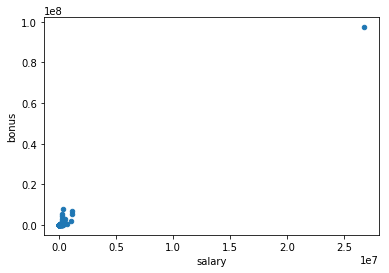

In [5]:
data_ML = data.drop('email_address',axis=1)
data_ML.plot.scatter('salary','bonus')
data_ML.drop(['LOCKHART EUGENE E','THE TRAVEL AGENCY IN THE PARK','TOTAL'],inplace=True)
print('Printing INDEX')
print(data_ML.index)
data_ML['salary'].idxmax()

# After Dropping The Outlier

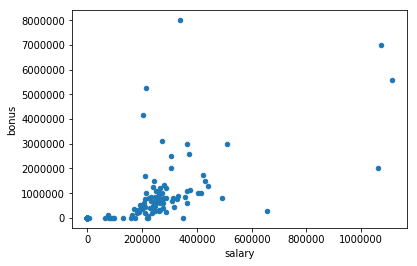

In [6]:
data_ML.plot.scatter('salary','bonus')

In [7]:
enronData = data_ML
enronData

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,0.0,1729541.0,13868.0,2195.000000,47.000000,65.000000,0.0,304805.0,152.0,False,126027.0,-126027.0,201955.0,1407.000000,2902.000000,4484442.0,1729541.0
BADUM JAMES P,0.0,178980.0,0.0,0.0,257817.0,3486.0,608.790698,64.895349,41.232558,0.0,0.0,0.0,False,0.0,0.0,0.0,1176.465116,2073.860465,182466.0,257817.0
BANNANTINE JAMES M,0.0,0.0,-5104.0,0.0,4046157.0,56301.0,29.000000,39.000000,0.000000,0.0,0.0,864523.0,False,1757552.0,-560222.0,477.0,465.000000,566.000000,916197.0,5243487.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,608.790698,64.895349,41.232558,0.0,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,1176.465116,2073.860465,5634343.0,10623258.0
BAY FRANKLIN R,400000.0,260455.0,-201641.0,0.0,0.0,129142.0,608.790698,64.895349,41.232558,0.0,0.0,69.0,False,145796.0,-82782.0,239671.0,1176.465116,2073.860465,827696.0,63014.0
BAZELIDES PHILIP J,0.0,684694.0,0.0,0.0,1599641.0,0.0,608.790698,64.895349,41.232558,0.0,93750.0,874.0,False,0.0,0.0,80818.0,1176.465116,2073.860465,860136.0,1599641.0
BECK SALLY W,700000.0,0.0,0.0,0.0,0.0,37172.0,4343.000000,144.000000,386.000000,0.0,0.0,566.0,False,126027.0,0.0,231330.0,2639.000000,7315.000000,969068.0,126027.0
BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,0.0,953136.0,17355.0,484.000000,228.000000,108.000000,0.0,0.0,210698.0,True,157569.0,0.0,213999.0,5521.000000,7991.000000,5501630.0,1110705.0
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,3285.0,0.0,608.790698,64.895349,41.232558,0.0,0.0,0.0,False,0.0,44093.0,0.0,1176.465116,2073.860465,102500.0,-44093.0
BERBERIAN DAVID,0.0,0.0,0.0,0.0,1624396.0,11892.0,608.790698,64.895349,41.232558,0.0,0.0,0.0,False,869220.0,0.0,216582.0,1176.465116,2073.860465,228474.0,2493616.0


# Creating New Features

* I will create two new features here: fraction of ‘to_messages’ received from a POI; - fraction of ‘from_messages’ sent to a POI.

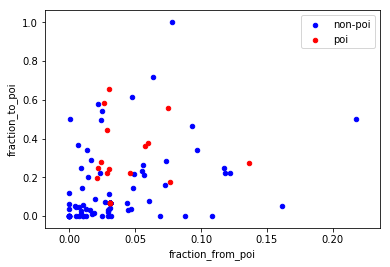

In [8]:
enronData['fraction_from_poi'] = enronData['from_poi_to_this_person'] / enronData['to_messages']
enronData['fraction_to_poi'] = enronData['from_this_person_to_poi'] / enronData['from_messages']

ax = enronData[enronData['poi'] == False].plot.scatter(x='fraction_from_poi', y='fraction_to_poi', color='blue', label='non-poi')
enronData[enronData['poi'] == True].plot.scatter(x='fraction_from_poi', y='fraction_to_poi', color='red', label='poi', ax=ax)


# Classifiers, and Tuning Strategies
For model building, I will use the following strategies:
1) Scaling the features, and for that purpose I will use the MinMaxScaler from the
   sklearn. Many machine learning algorithms are expected to perform better with scaled data.
2) Tuning the algorithms by adjusting parameters in order to maximise the evaluation metrics,
    and for that purpose I will use the GridSearchCV from sklearn. Among the possibilities,
    GridSearchCV exhaustively searches for the best parameter that optimizes the chosen
    parameter
3) The main purpose of splitting our data into train and test is to see how well our model
    generalizes to the unseen data. We are really no way interested in the accuracies on training
    data, but on the new unseen data. Although I used train_test_split function before, there 
    are more robust ways of assessing how well the model generalizes than just doing a single 
    split of the data. It's a good practice to split the data into training, validation and test 
    set. The model being trained on a training set is tuned to increase its performance on 
    the validation set, and then the final efficiency is checked on the test set. 
    Among the various cross-validation strategies, I decided to go with the StratifiedShuffleSplit, 
    and the main reason of chosing it is because the our data is small, and we do want to have
    the right representation of both the target and independent variables in the split. 
    
    We will check various parameters against each model:
    1) Model Generalizability (Mean f1 score)
    2) The Best Cross Validation Accuracy 
    3) The Best Parameters
    4) The Best Estimator Score
    5) The Classification Report


# Gaussian Naive-Bayes

In [9]:
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments', 
                 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 
                 'total_stock_value', 'to_messages', 'from_messages', 'from_this_person_to_poi', 
                 'from_poi_to_this_person', 'shared_receipt_with_poi', 'fraction_from_poi', 'fraction_to_poi']


data_dict = enronData.to_dict(orient='index')

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
y, X = targetFeatureSplit(data)
X = np.array(X)
y = np.array(y)

### Cross-validation
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

SCALER = [None, StandardScaler()]
SELECTOR__K = [10, 13, 15, 18, 'all']
REDUCER__N_COMPONENTS = [2, 4, 6, 8, 10]



In [10]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        ('reducer', PCA(random_state=42)),
        ('classifier', GaussianNB())
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,
    'reducer__n_components': REDUCER__N_COMPONENTS
}

gnb_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
gnb_grid.fit(X, y)
evaluate_model(gnb_grid, X, y, sss)
print(gnb_grid.best_estimator_)
clf = gnb_grid.best_estimator_
test_classifier(gnb_grid.best_estimator_, my_dataset, features_list)



Nested f1 score: 0.2745238095238095
Best parameters: {'reducer__n_components': 2, 'scaler': None, 'selector__k': 10}
Mean Accuracy: 0.8965517241379309
Mean Precision: 0.65
Mean Recall: 0.4
Mean f1: 0.4780952380952381
Pipeline(memory=None,
     steps=[('scaler', None), ('selector', SelectKBest(k=10, score_func=<function f_classif at 0x000000000CBEE6A8>)), ('reducer', PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', GaussianNB(priors=None))])
Pipeline(memory=None,
     steps=[('scaler', None), ('selector', SelectKBest(k=10, score_func=<function f_classif at 0x000000000CBEE6A8>)), ('reducer', PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', GaussianNB(priors=None))])
	Accuracy: 0.87233	Precision: 0.54098	Recall: 0.28050	F1: 0.36944	F2: 0.31039
	Total predictions: 15000	True positives:  561	False positives:  476	False negative

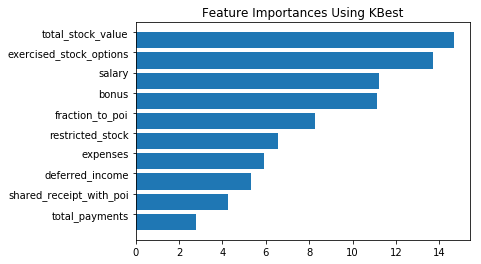

In [11]:
kbest = gnb_grid.best_estimator_.named_steps['selector']

features_array = np.array(features_list)
features_array = np.delete(features_array, 0)
indices = np.argsort(kbest.scores_)[::-1]
k_features = kbest.get_support().sum()

features = []
for i in range(k_features):
    features.append(features_array[indices[i]])

features = features[::-1]
scores = kbest.scores_[indices[range(k_features)]][::-1]

plt.barh(range(k_features), scores)
plt.yticks(np.arange(0.4, k_features), features)
plt.title('Feature Importances Using KBest')
plt.show()


In [12]:
CLF_PICKLE_FILENAME = "my_classifier_gaussian.pkl"
DATASET_PICKLE_FILENAME = "my_dataset_gaussian.pkl"
FEATURE_LIST_FILENAME = "my_feature_list_gaussian.pkl"

def my_dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "wb") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "wb") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "wb") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)


In [13]:
my_dump_classifier_and_data(clf,my_dataset,features_list)

# SVM Classifier

In [14]:

C_PARAM = np.logspace(-2, 3, 6)
GAMMA_PARAM = np.logspace(-4, 1, 6)
CLASS_WEIGHT = ['balanced', None]
KERNEL = ['rbf', 'sigmoid']

### comment to perform a full hyperparameter search
# SCALER = [StandardScaler()]
# SELECTOR__K = [18]
# REDUCER__N_COMPONENTS = [10]
# C_PARAM = [100]
# GAMMA_PARAM = [.01]
# CLASS_WEIGHT = ['balanced']
# KERNEL = ['sigmoid']
###################################################

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        ('reducer', PCA(random_state=42)),
        ('classifier', SVC())
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,
    'reducer__n_components': REDUCER__N_COMPONENTS,
    'classifier__C': C_PARAM,
    'classifier__gamma': GAMMA_PARAM,
    'classifier__class_weight': CLASS_WEIGHT,
    'classifier__kernel': KERNEL
}

svc_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

evaluate_model(svc_grid, X, y, sss)

test_classifier(svc_grid.best_estimator_, my_dataset, features_list)

clf_svc = svc_grid.best_estimator_


Nested f1 score: 0.2546103896103896
Best parameters: {'classifier__C': 100.0, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.01, 'classifier__kernel': 'sigmoid', 'reducer__n_components': 8, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'selector__k': 'all'}
Mean Accuracy: 0.8137931034482758
Mean Precision: 0.43765873015873014
Mean Recall: 0.875
Mean f1: 0.575982905982906
Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selector', SelectKBest(k='all', score_func=<function f_classif at 0x000000000CBEE6A8>)), ('reducer', PCA(copy=True, iterated_power='auto', n_components=8, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('c...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.75940	Precision: 0.33173	Recall: 0.79300	F1: 0.46778	F2: 0.62045
	Total predictions: 15000	True positives: 1586	False positives: 3195	False neg

In [15]:
CLF_PICKLE_FILENAME = "my_classifier_svc.pkl"
DATASET_PICKLE_FILENAME = "my_dataset_svc.pkl"
FEATURE_LIST_FILENAME = "my_feature_list_svc.pkl"

def my_dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "wb") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "wb") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "wb") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

my_dump_classifier_and_data(clf_svc,my_dataset,features_list)

# Decision Tree Classifier

In [16]:
CRITERION = ['gini', 'entropy']
SPLITTER = ['best', 'random']
MIN_SAMPLES_SPLIT = [2, 4, 6, 8]
CLASS_WEIGHT = ['balanced', None]

### comment to perform a full hyperparameter search
# SCALER = [StandardScaler()]
# SELECTOR__K = [18]
# REDUCER__N_COMPONENTS = [2]
# CRITERION = ['gini']
# SPLITTER = ['random']
# MIN_SAMPLES_SPLIT = [8]
# CLASS_WEIGHT = ['balanced']
###################################################

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        ('reducer', PCA(random_state=42)),
        ('classifier', DecisionTreeClassifier())
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,
    'reducer__n_components': REDUCER__N_COMPONENTS,
    'classifier__criterion': CRITERION,
    'classifier__splitter': SPLITTER,
    'classifier__min_samples_split': MIN_SAMPLES_SPLIT,
    'classifier__class_weight': CLASS_WEIGHT,
}

tree_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
print('working')

evaluate_model(tree_grid, X, y, sss)
print('working')

test_classifier(tree_grid.best_estimator_, my_dataset, features_list)

clf_tree = tree_grid.best_estimator_


working
Nested f1 score: 0.3135347985347986
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__min_samples_split': 6, 'classifier__splitter': 'random', 'reducer__n_components': 6, 'scaler': None, 'selector__k': 15}
Mean Accuracy: 0.7793103448275861
Mean Precision: 0.29500000000000004
Mean Recall: 0.4
Mean f1: 0.32071428571428573
working
Pipeline(memory=None,
     steps=[('scaler', None), ('selector', SelectKBest(k=15, score_func=<function f_classif at 0x000000000CBEE6A8>)), ('reducer', PCA(copy=True, iterated_power='auto', n_components=6, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', DecisionTreeClassifier(class_weight='balanc...    min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'))])
	Accuracy: 0.76173	Precision: 0.25829	Recall: 0.42050	F1: 0.32002	F2: 0.37358
	Total predictions: 15000	True positives:  841	False positives: 2415	False negatives: 1159	True ne

In [17]:
CLF_PICKLE_FILENAME = "my_classifier_tree.pkl"
DATASET_PICKLE_FILENAME = "my_dataset_tree.pkl"
FEATURE_LIST_FILENAME = "my_feature_list_tree.pkl"

def my_dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "wb") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "wb") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "wb") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

my_dump_classifier_and_data(clf_tree,my_dataset,features_list)